### Importing packages

In [7]:
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

tqdm.pandas()

In [8]:
import warnings
warnings.filterwarnings('ignore')

### Reading in dataset

In [9]:
df_ACL_2020 = pd.read_csv("./Data/ACL_2020.csv")
df_EMNLP_2020 = pd.read_csv("./Data/EMNLP_2020.csv")
df_EACL_2021 = pd.read_csv("./Data/EACL_2021.csv")
df_ACL_JCNLP_2021 = pd.read_csv("./Data/ACL_JCNLP_2021.csv")
df_NAACL_2021 = pd.read_csv("./Data/NAACL_2021.csv")

In order to get the full and abstracted text, we use the 74k extracted dataset from earlier

In [10]:
df_base = pd.read_parquet("./Data/acl-publication-info.74k.parquet")

In [11]:
df_base = df_base[['title', 'author', "abstract", "full_text"]]

In [12]:
df_base['title'] = df_base['title'].str.replace('{','')
df_base['title'] = df_base['title'].str.replace('}','')

In [13]:
#45 rows dropped because entries are mismatched or cannot be found in original dataset
df_ACL_2020 = df_ACL_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#65 rows dropped because entries are mismatched or cannot be found in original dataset
df_EMNLP_2020 = df_EMNLP_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#10 rows dropped because entries are mismatched or cannot be found in original dataset
df_EACL_2021 = df_EACL_2021.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#21 rows dropped because entries are mismatched or cannot be found in original dataset
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#33 rows dropped because entries are mismatched or cannot be found in original dataset
df_NAACL_2021 = df_NAACL_2021.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])

In [14]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() == 0]

,Labels,Paper Name,Author Names,title,author,abstract,full_text
49,Dialogue and Interactive Systems,Cross Copy Network for Dialogue Generation,"Changzhen Ji, Xin Zhou, Yating Zhang, Xiaozhon...",Cross Copy Network for Dialogue Generation,"Ji, Changzhen and\nZhou, Xin and\nZhang, Yat...",,"v w 8 12 b8 2 8*$(' @:.% + $(++ $* n' (m$+ ,% ..."
546,Semantics: Lexical Semantics,When Hearst Is not Enough: Improving Hypernymy...,"Changlong Yu, Jialong Han, Peifeng Wang, Yangq...",When Hearst Is not Enough: Improving Hypernymy...,"Yu, Changlong and\nHan, Jialong and\nWang, P...",,When Hearst Is not Enough: Improving Hypernymy...
658,Speech and Multimodality,CMU-MOSEAS: A Multimodal Language Dataset for ...,"AmirAli Bagher Zadeh, Yansheng Cao, Simon Hess...",CMU-MOSEAS: A Multimodal Language Dataset for ...,"Bagher Zadeh, AmirAli and\nCao, Yansheng and...",,Abstract Modeling multimodal language is a cor...


In [15]:
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_ACL_2020 = df_ACL_2020[df_ACL_2020['abstract'].str.len() != 0]
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_EMNLP_2020 = df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() != 0]
#4 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021[df_ACL_JCNLP_2021['abstract'].str.len() != 0]
#4 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_NAACL_2021 = df_NAACL_2021[df_NAACL_2021['abstract'].str.len() != 0]

In [16]:
df_ACL_2020 = df_ACL_2020[['Labels', 'Paper Name', 'abstract']]
df_EMNLP_2020 = df_EMNLP_2020[['Labels', 'Paper Name', 'abstract']]
df_EACL_2021 = df_EACL_2021[['Labels', 'Paper Name', 'abstract']]
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021[['Labels', 'Paper Name', 'abstract']]
df_NAACL_2021 = df_NAACL_2021[['Labels', 'Paper Name', 'abstract']]

### Looking the the distribution of the classes

In [48]:
df_ACL_2020_labels_count = df_ACL_2020.groupby(['Labels'])['Labels'].count()
df_EMNLP_2020_labels_count = df_EMNLP_2020.groupby(['Labels'])['Labels'].count()
df_EACL_2021_labels_count = df_EACL_2021.groupby(['Labels'])['Labels'].count()
df_ACL_JCNLP_2021_labels_count = df_ACL_JCNLP_2021.groupby(['Labels'])['Labels'].count()
df_NAACL_2021_labels_count = df_NAACL_2021.groupby(['Labels'])['Labels'].count()

In [49]:
df_count =  pd.concat([df_ACL_2020_labels_count, df_EMNLP_2020_labels_count, df_EACL_2021_labels_count, df_ACL_JCNLP_2021_labels_count, df_NAACL_2021_labels_count], axis=1)

In [50]:
df_count.columns = ['ACL_2020 Count', 'EMLP_2020 Count', 'EACL_2021 Count', 'ACL_JCNLP_2021 Count', 'NAACL_2021 Count' ]

In [51]:
df_count = df_count.reset_index()

We can see that some labels do not exist within EMLP. To note when we are splitting the two groups into train and test set

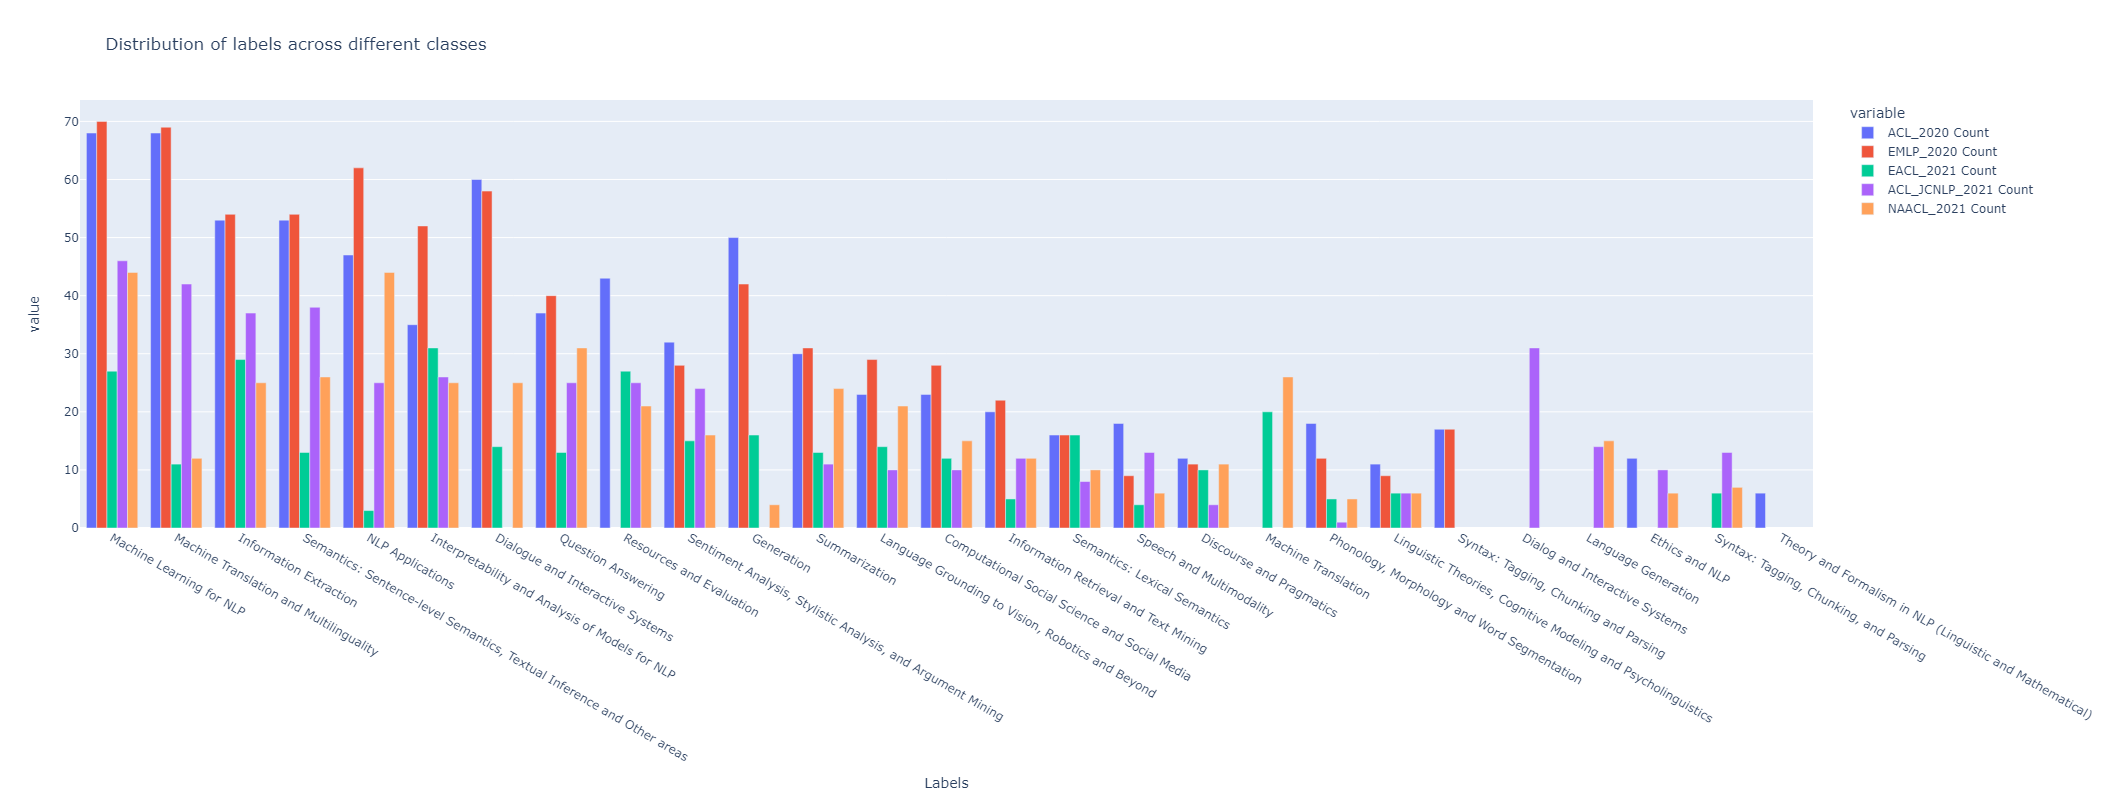

In [53]:
fig = px.bar(df_count, x="Labels", y=["ACL_2020 Count", "EMLP_2020 Count", "EACL_2021 Count", "ACL_JCNLP_2021 Count", "NAACL_2021 Count"], title="Distribution of labels across different classes", barmode='group',
             width=1600, height=800).update_xaxes(categoryorder = "total descending")
fig.show()

In [56]:
df_count_total = df_count.fillna(0)

In [60]:
df_count_total["Total"] = df_count_total.sum(axis = 1)

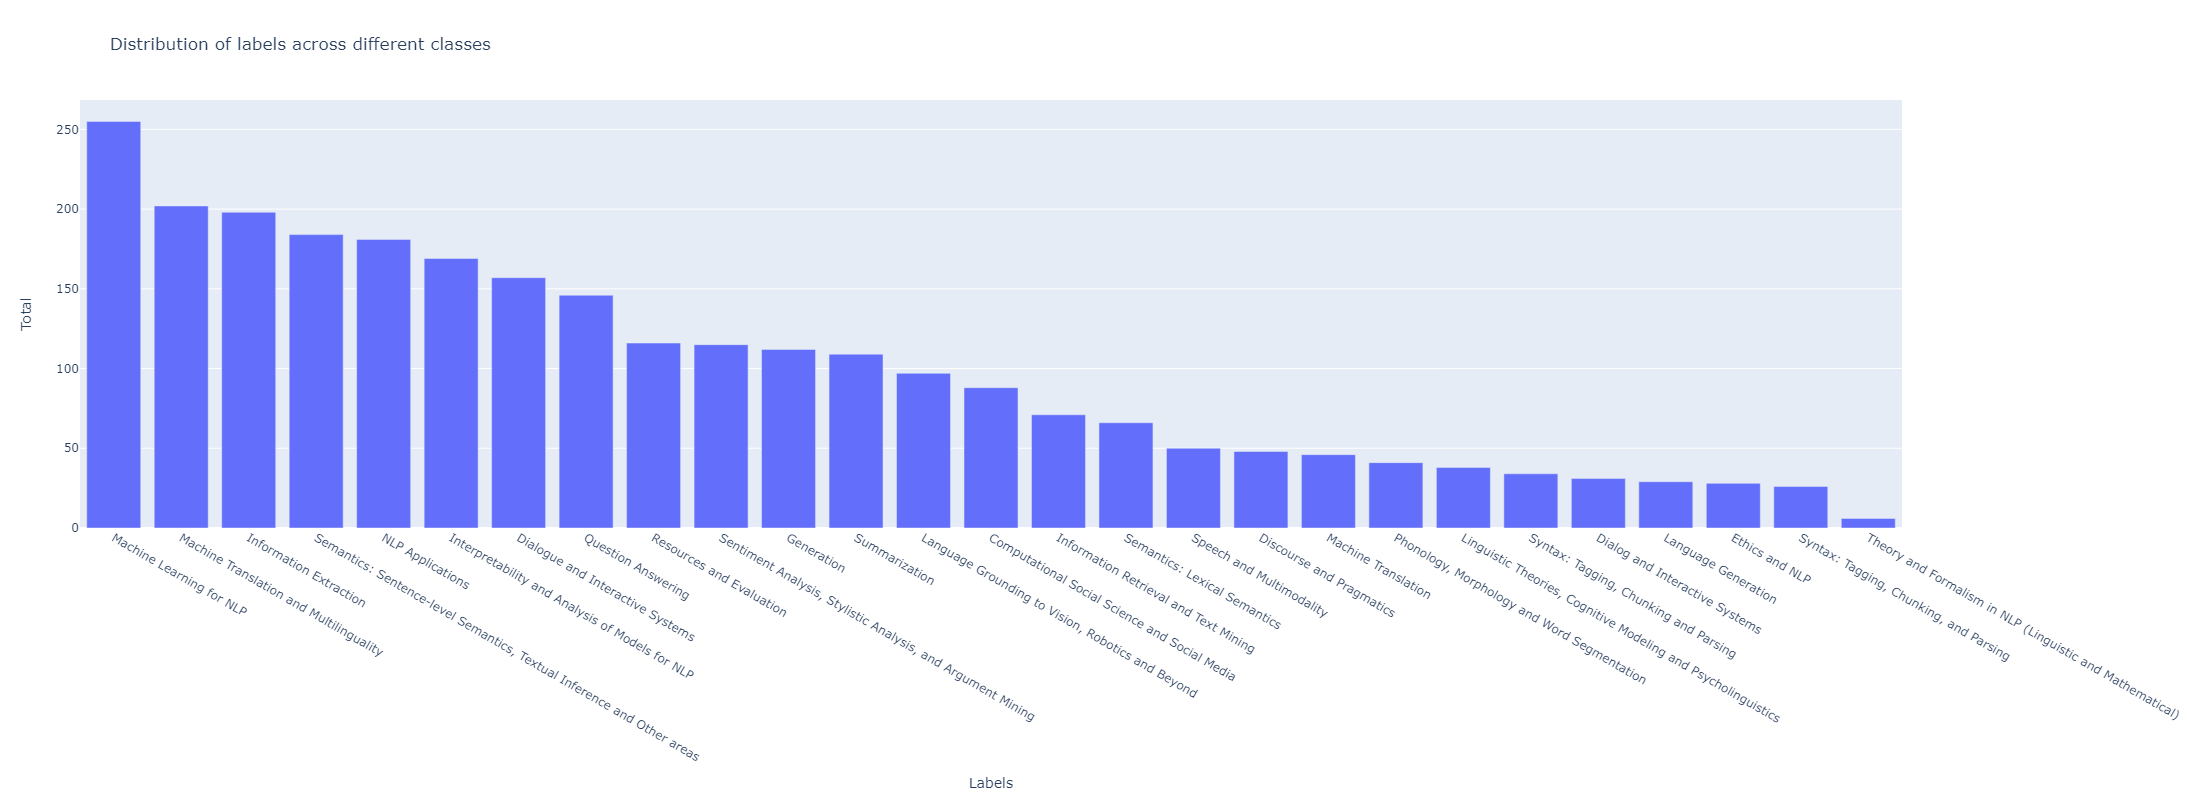

In [62]:
fig = px.bar(df_count_total, x="Labels", y="Total", title="Distribution of labels across different classes", barmode='group',
             width=1600, height=800).update_xaxes(categoryorder = "total descending")
fig.show()

### Looking at full text

Some text like the one below has alot more information than just the abstract, should check to see how the abstract was created. The text below seems to take text from figures as well.

In [18]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.contains('Being able to perform in-depth chat with humans in a closed domain')]

,Labels,Paper Name,abstract
73,Dialogue and Interactive Systems,MovieChats: Chat like Humans in a Closed Domain,Being able to perform in-depth chat with human...


Some text like the one below has phrases that are missing spaces, which might cause the text to become uncleaned. Will see how we can fix that at a later date

In [19]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.contains('minimallysupervise')]

,Labels,Paper Name,abstract
2,Computational Social Science and Social Media,Weakly Supervised Learning of Nuanced Frames f...,"In this paper, we suggest a minimallysupervise..."


### Looking at zero shot classifer (bart-large-mnli)

In [63]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli", 
                      device  = 0)

In [21]:
def classify_bart_large_mnli_ACL_labels(row):
    
    candidate_labels = list(df_ACL_2020['Labels'].unique())
    
    sequence_to_classify = row['abstract']
    actual_label = row['Labels']
    
    out = classifier(sequence_to_classify, candidate_labels)
    prob_score = out['scores']
    labels = out['labels']
    
    # Returns the score of the actual label
    idx = labels.index(actual_label)
    label_score = prob_score[idx]
    
    return out, prob_score[0], labels[0], label_score

In [22]:
def classify_bart_large_mnli_EMNLP_labels(row):
    
    candidate_labels = list(df_EMNLP_2020['Labels'].unique())
    
    sequence_to_classify = row['abstract']
    actual_label = row['Labels']
    
    out = classifier(sequence_to_classify, candidate_labels)
    prob_score = out['scores']
    labels = out['labels']
    
    # Returns the score of the actual label
    idx = labels.index(actual_label)
    label_score = prob_score[idx]
    
    return out, prob_score[0], labels[0], label_score

In [23]:
sequence_to_classify = df_ACL_2020.iloc[107].abstract
candidate_labels = list(df_ACL_2020['Labels'].unique())

out = classifier(sequence_to_classify, candidate_labels)

In [24]:
df_ACL_2020_results = df_ACL_2020.progress_apply(lambda x: pd.Series(classify_bart_large_mnli_ACL_labels(x), index=['Full Prediction', 'Max Score', 'Max Label', 'Actual Label Score']), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 859/859 [26:39<00:00,  1.86s/it]


In [25]:
df_EMNLP_2020_results = df_EMNLP_2020.progress_apply(lambda x: pd.Series(classify_bart_large_mnli_EMNLP_labels(x), index=['Full Prediction', 'Max Score', 'Max Label', 'Actual Label Score']), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [16:17<00:00,  1.37s/it]


In [26]:
df_ACL_2020 = pd.concat([df_ACL_2020, df_ACL_2020_results], axis = 1)

In [27]:
df_EMNLP_2020 = pd.concat([df_EMNLP_2020, df_EMNLP_2020_results], axis = 1)

In [28]:
df_ACL_2020.to_csv("./Data/Pred/BART/ACL_2022_bart_pred_231122.csv", index = False)
df_EMNLP_2020.to_csv("./Data/Pred/BART/EMNLP_2020_bart_pred_231122.csv", index = False)

In [29]:
df_ACL_2020 = pd.read_csv("./Data/Pred/BART/ACL_2022_bart_pred_231122.csv")
df_EMNLP_2020 = pd.read_csv("./Data/Pred/BART/EMNLP_2020_bart_pred_231122.csv")

### Prediction for ACL 2020 dataset

In [30]:
idx_labels = list(df_ACL_2020["Labels"].unique())

cm = confusion_matrix(df_ACL_2020['Labels'], df_ACL_2020['Max Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

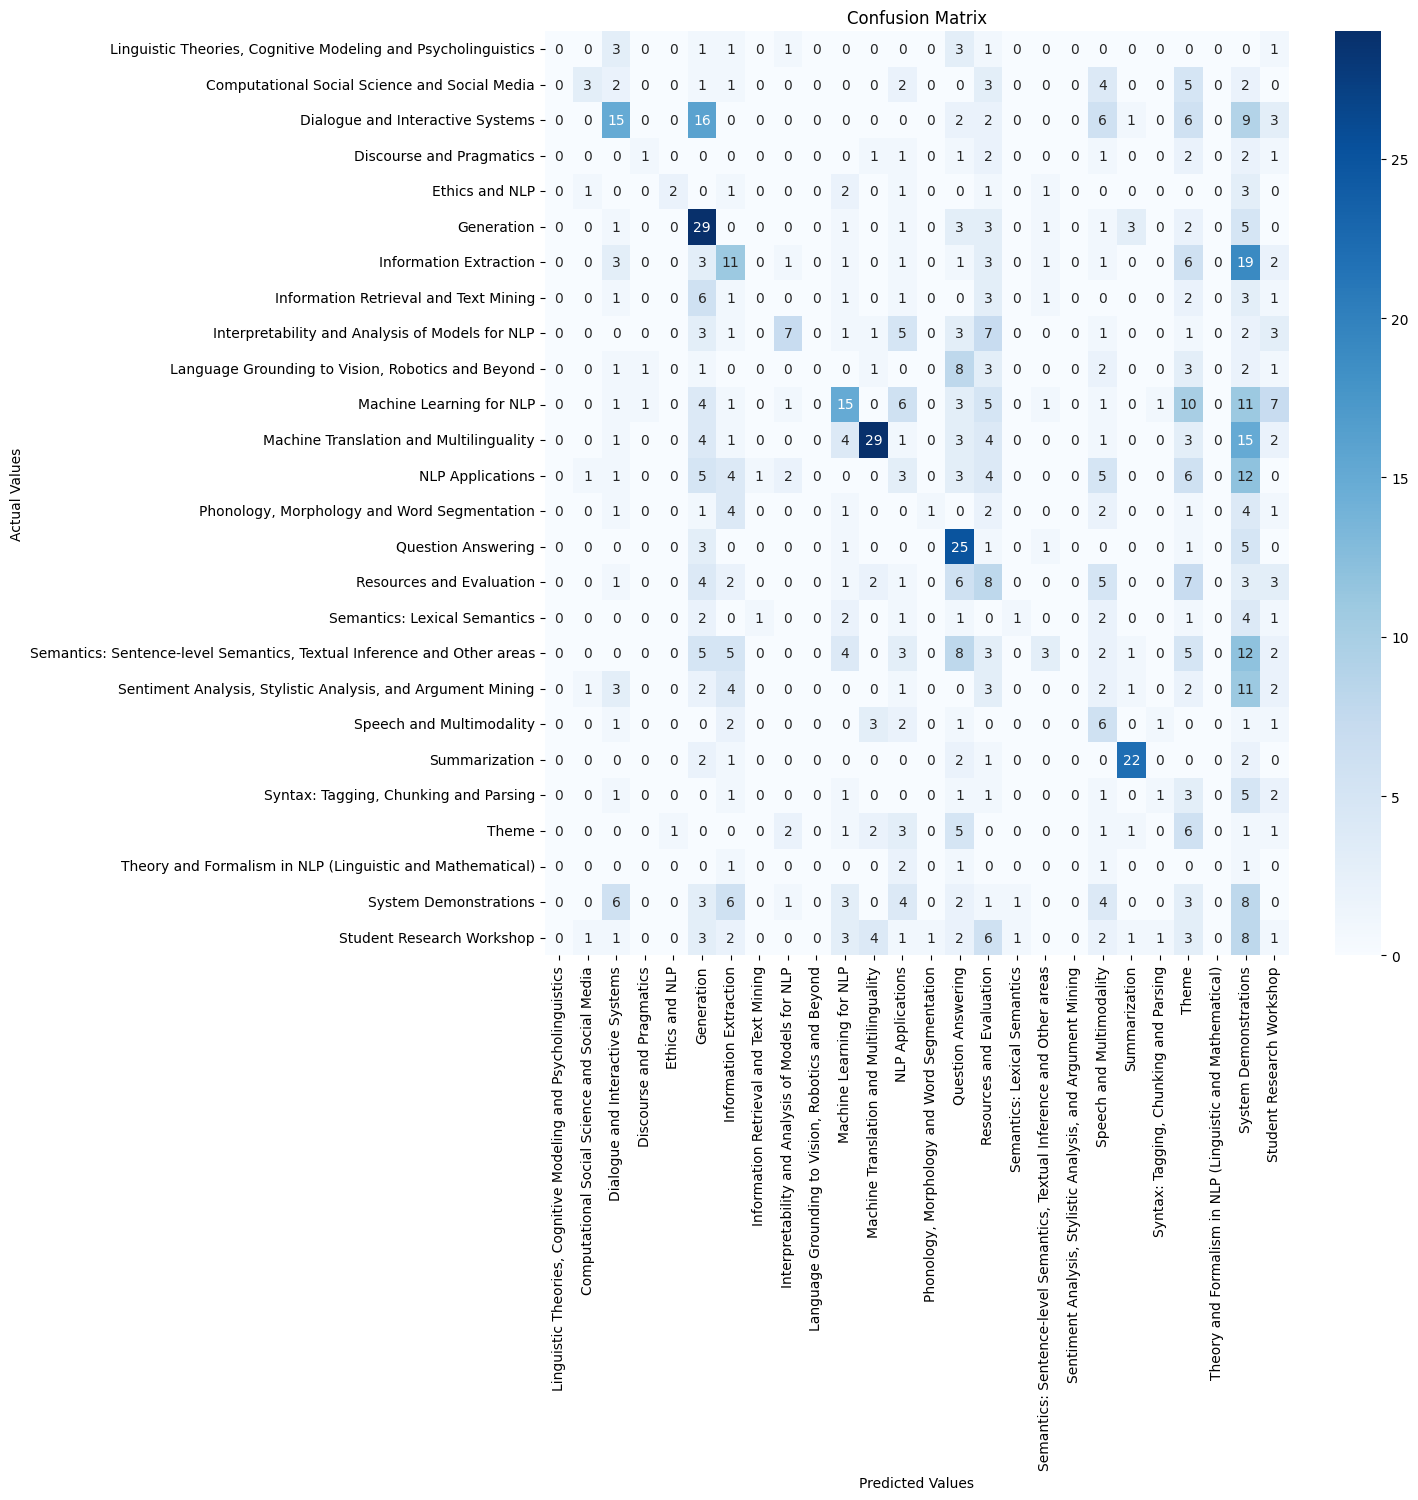

In [31]:
#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Classification results

In [32]:
print(classification_report(df_ACL_2020['Labels'], df_ACL_2020['Max Label']))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.43      0.13      0.20        23
                                      Dialogue and Interactive Systems       0.35      0.25      0.29        60
                                              Discourse and Pragmatics       0.33      0.08      0.13        12
                                                        Ethics and NLP       0.67      0.17      0.27        12
                                                            Generation       0.30      0.58      0.39        50
                                                Information Extraction       0.22      0.21      0.21        53
                                 Information Retrieval and Text Mining       0.00      0.00      0.00        20
                       Interpretability and Analysis of Models for NLP       0.47      0.20      0.28  

In [33]:
df_ACL_2020["Label outcome"] = df_ACL_2020.apply(lambda x: x["Labels"] == x["Max Label"], axis = 1)

In [34]:
df_ACL_2020_outcome = df_ACL_2020[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')

In [35]:
df_ACL_2020_outcome = df_ACL_2020_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])

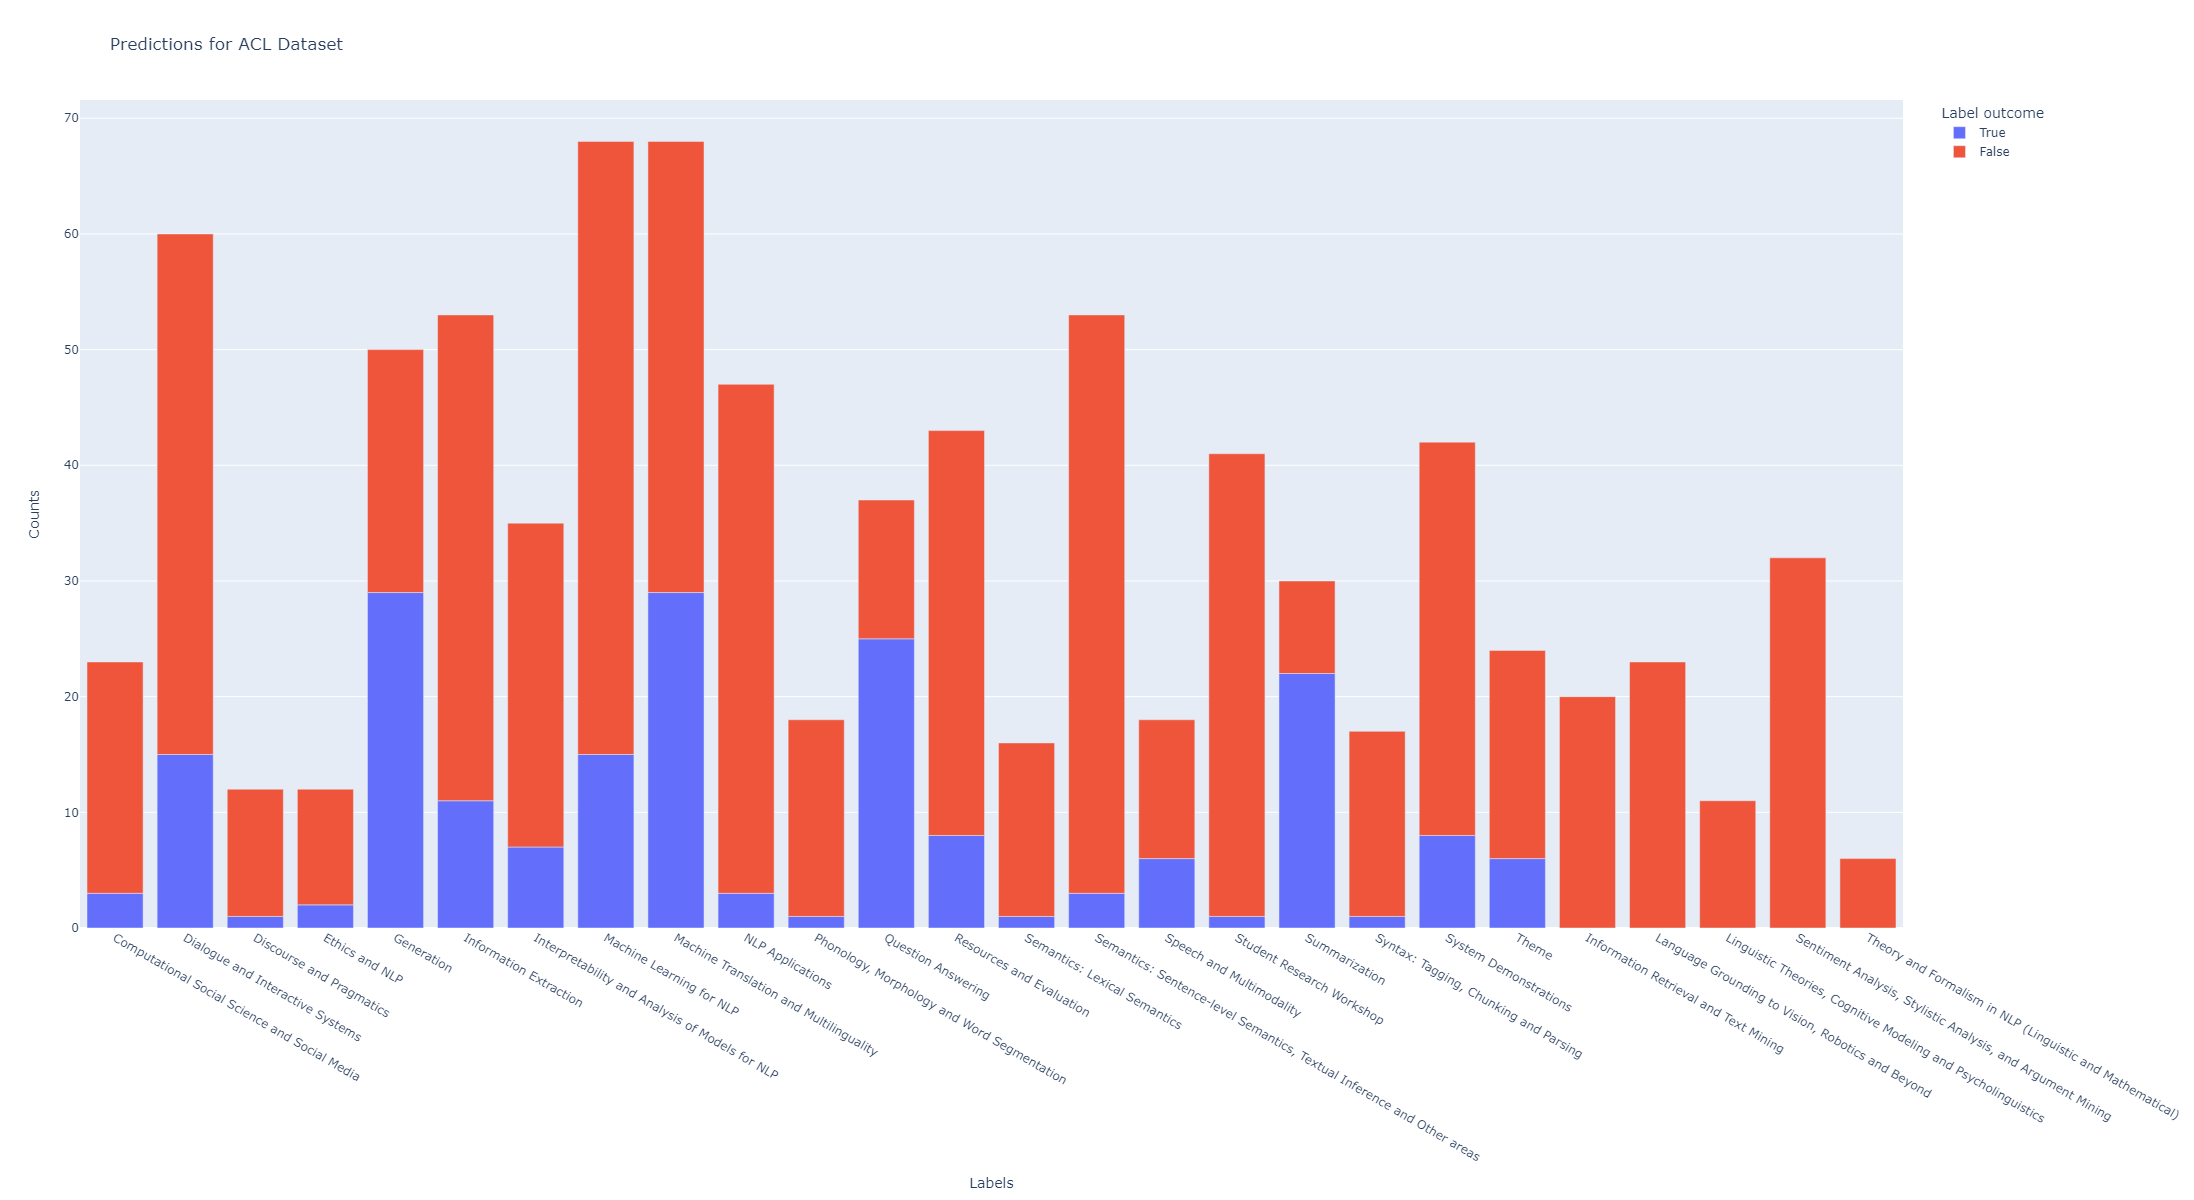

In [36]:
import plotly.express as px

fig = px.bar(df_ACL_2020_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for ACL Dataset",
             width=1800, height=1200)
fig.show()

### Prediction for EMNLP 2020 dataset

In [37]:
idx_labels = list(df_EMNLP_2020["Labels"].unique())

cm = confusion_matrix(df_EMNLP_2020['Labels'], df_EMNLP_2020['Max Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

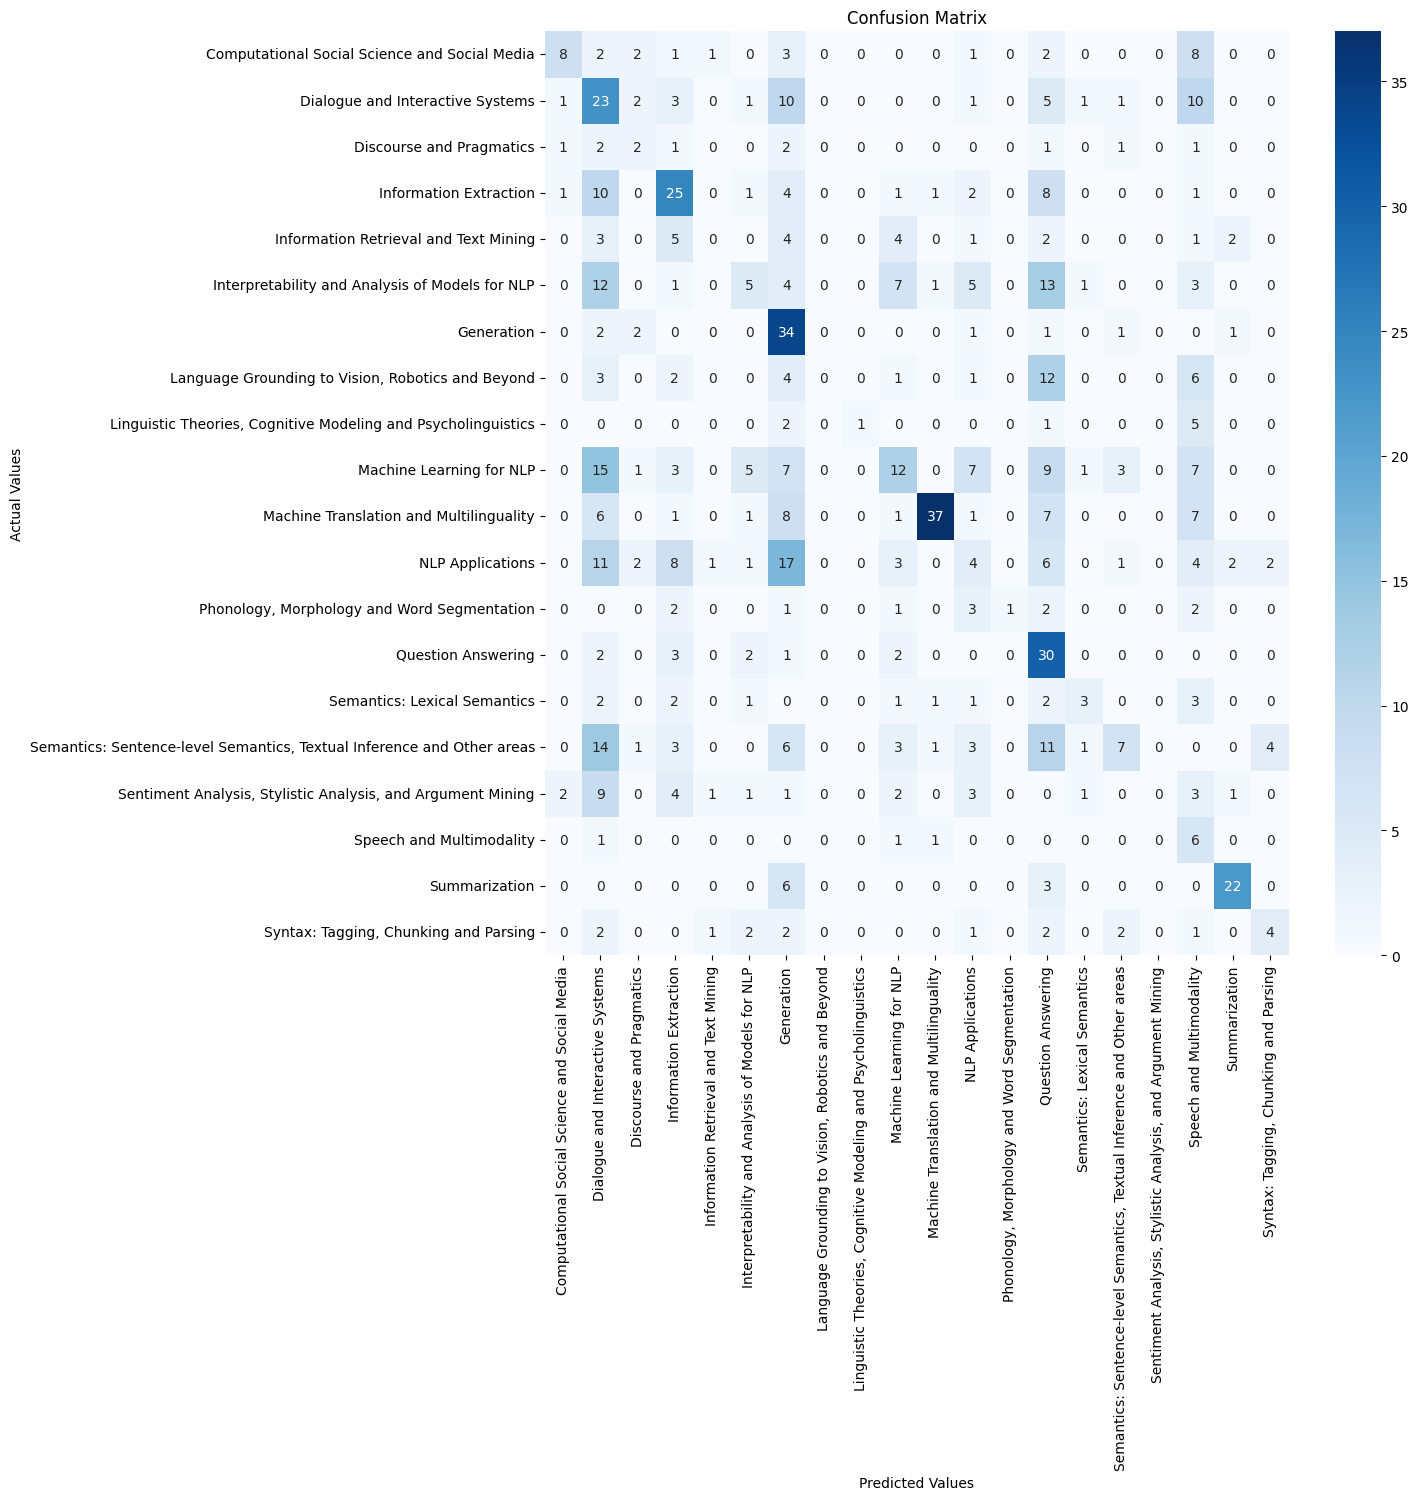

In [38]:
#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Classifcation results

In [39]:
print(classification_report(df_EMNLP_2020['Labels'], df_EMNLP_2020['Max Label']))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.62      0.29      0.39        28
                                      Dialogue and Interactive Systems       0.19      0.40      0.26        58
                                              Discourse and Pragmatics       0.17      0.18      0.17        11
                                                            Generation       0.29      0.81      0.43        42
                                                Information Extraction       0.39      0.46      0.42        54
                                 Information Retrieval and Text Mining       0.00      0.00      0.00        22
                       Interpretability and Analysis of Models for NLP       0.25      0.10      0.14        52
                     Language Grounding to Vision, Robotics and Beyond       0.00      0.00      0.00  

In [40]:
df_EMNLP_2020["Label outcome"] = df_EMNLP_2020.apply(lambda x: x["Labels"] == x["Max Label"], axis = 1)

In [41]:
df_EMNLP_2020_outcome = df_EMNLP_2020[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')

In [42]:
df_EMNLP_2020_outcome = df_EMNLP_2020_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])

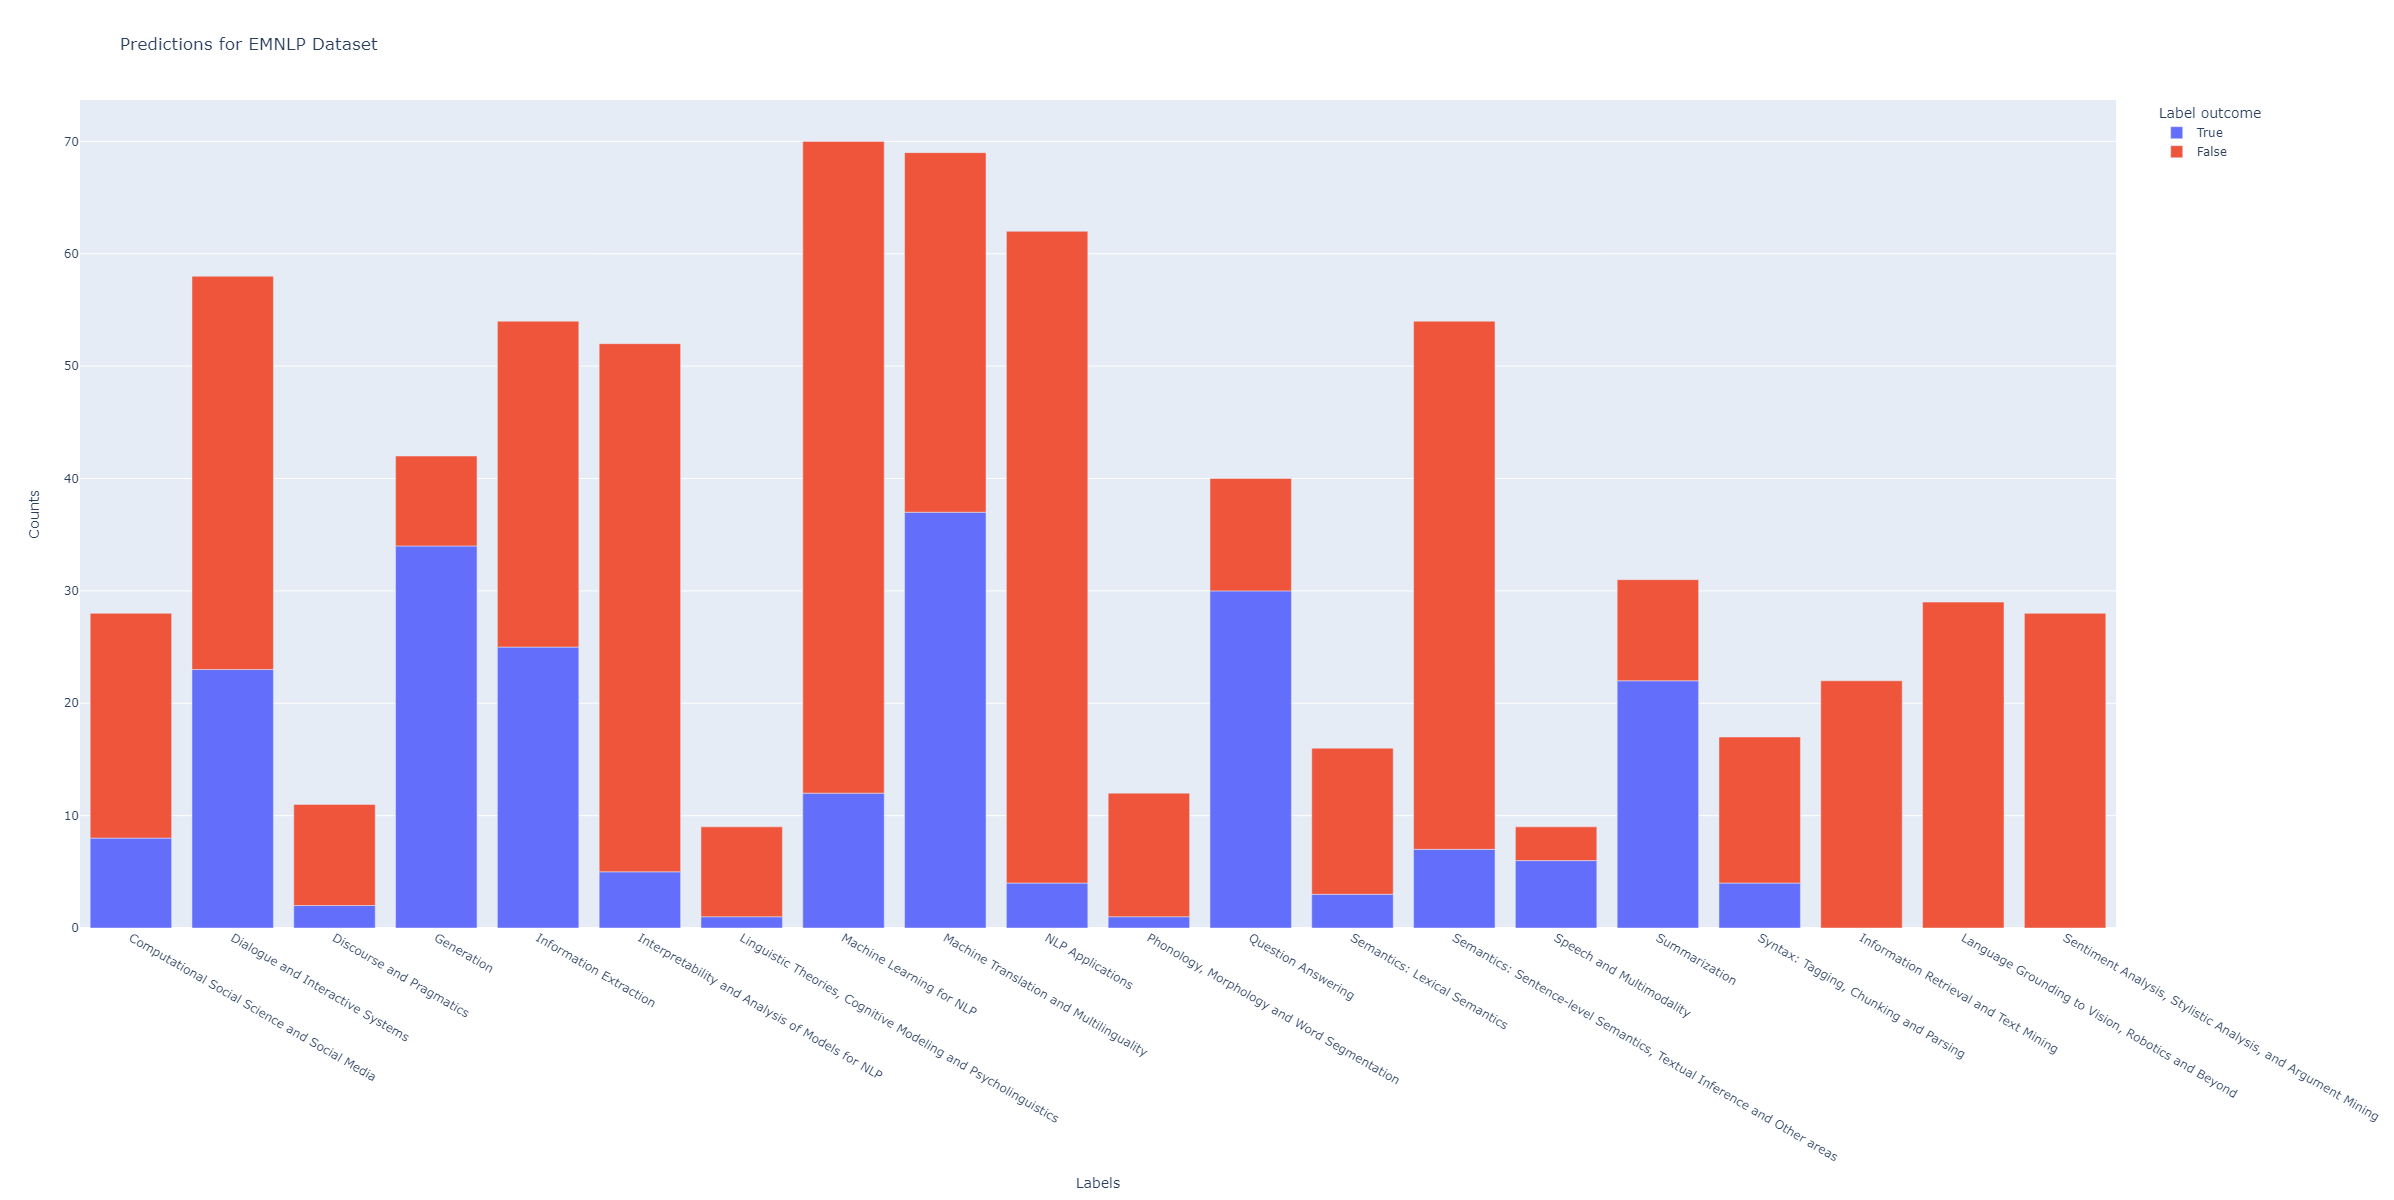

In [43]:
import plotly.express as px

fig = px.bar(df_EMNLP_2020_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for EMNLP Dataset",
             width=1800, height=1200)
fig.show()

### Accuracy breakdown by Labels

#### ACL 2020

In [44]:
df_ACL_2020_accuracy = df_ACL_2020_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)

In [45]:
df_ACL_2020_accuracy["Accuracy"] = df_ACL_2020_accuracy[True] / (df_ACL_2020_accuracy[False] + df_ACL_2020_accuracy[True]) * 100

In [46]:
df_ACL_2020_accuracy = df_ACL_2020_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_ACL_2020_accuracy

Label outcome,Labels,False,True,Accuracy
21,Summarization,8.0,22.0,73.333333
14,Question Answering,12.0,25.0,67.567568
4,Generation,21.0,29.0,58.000000
11,Machine Translation and Multilinguality,39.0,29.0,42.647059
19,Speech and Multimodality,12.0,6.0,33.333333
1,Dialogue and Interactive Systems,45.0,15.0,25.000000
24,Theme,18.0,6.0,25.000000
10,Machine Learning for NLP,53.0,15.0,22.058824
5,Information Extraction,42.0,11.0,20.754717
7,Interpretability and Analysis of Models for NLP,28.0,7.0,20.000000


#### EMNLP 2020

In [47]:
df_EMNLP_2020_accuracy = df_EMNLP_2020_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)

In [48]:
df_EMNLP_2020_accuracy["Accuracy"] = df_EMNLP_2020_accuracy[True] / (df_EMNLP_2020_accuracy[False] + df_EMNLP_2020_accuracy[True]) * 100

In [49]:
df_EMNLP_2020_accuracy = df_EMNLP_2020_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_EMNLP_2020_accuracy

Label outcome,Labels,False,True,Accuracy
3,Generation,8.0,34.0,80.952381
13,Question Answering,10.0,30.0,75.000000
18,Summarization,9.0,22.0,70.967742
17,Speech and Multimodality,3.0,6.0,66.666667
10,Machine Translation and Multilinguality,32.0,37.0,53.623188
4,Information Extraction,29.0,25.0,46.296296
1,Dialogue and Interactive Systems,35.0,23.0,39.655172
0,Computational Social Science and Social Media,20.0,8.0,28.571429
19,"Syntax: Tagging, Chunking and Parsing",13.0,4.0,23.529412
14,Semantics: Lexical Semantics,13.0,3.0,18.750000


In [50]:
sample_gen_ACL = df_ACL_2020[(df_ACL_2020['Labels'] == "Machine Translation and Multilinguality") & (df_ACL_2020["Label outcome"] == False)]["abstract"].sample(10)
[print(x + "\n") for x in sample_gen_ACL] 

Crosslingual word embeddings learned from monolingual embeddings have a crucial role in many downstream tasks, ranging from machine translation to transfer learning. Adversarial training has shown impressive success in learning crosslingual embeddings and the associated word translation task without any parallel data by mapping monolingual embeddings to a shared space. However, recent work has shown superior performance for non-adversarial methods in more challenging language pairs. In this article, we investigate adversarial autoencoder for unsupervised word translation and propose two novel extensions to it that yield more stable training and improved results. Our method includes regularization terms to enforce cycle consistency and input reconstruction, and puts the target encoders as an adversary against the corresponding discriminator. We use two types of refinement procedures sequentially after obtaining the trained encoders and mappings from the adversarial training, namely, ref

[None, None, None, None, None, None, None, None, None, None]

In [51]:
sample_gen_EMNLP = df_EMNLP_2020[(df_EMNLP_2020['Labels'] == "Machine Translation and Multilinguality") & (df_EMNLP_2020["Label outcome"] == False)]["abstract"].sample(10)
[print(x + "\n") for x in sample_gen_EMNLP] 

The translation quality estimation (QE) task, particularly the QE as a Metric task, aims to evaluate the general quality of a translation based on the translation and the source sentence without using reference translations. Supervised learning of this QE task requires human evaluation of translation quality as training data. Human evaluation of translation quality can be performed in different ways, including assigning an absolute score to a translation or ranking different translations. In order to make use of different types of human evaluation data for supervised learning, we present a multi-task learning QE model that jointly learns two tasks: score a translation and rank two translations. Our QE model exploits crosslingual sentence embeddings from pretrained multilingual language models. We obtain new state-of-the-art results on the WMT 2019 QE as a Metric task and outperform sentBLEU on the WMT 2019 Metrics task.

We present LAReQA, a challenging new benchmark for language-agnos

[None, None, None, None, None, None, None, None, None, None]

### Testing hypothesis: Is the zero-sort learning model just picking up keywords from the labels?

1. Locate all the text that contain the label keywords
2. If the hypothesis is True, then the correct entries will have keywords and the wrong entries will not have keywords (or at least have a higher proportion)

In [52]:
def check_presence(row):

    stemmer = SnowballStemmer(language='english')
    
    interest = row['Labels'].translate(str.maketrans('', '', string.punctuation)).lower()
    sequence = row['abstract'].translate(str.maketrans('', '', string.punctuation)).lower()
    
    interest_lst = [stemmer.stem(token) for token in interest.split(" ")]
    sequence_lst = [stemmer.stem(token) for token in sequence.split(" ")]
    
    stop_words = stopwords.words('english')
    
    check = False
    
    for txt in interest_lst:
        if txt in sequence_lst and txt not in stop_words:
            check = True
    
    return check

In [53]:
df_ACL_2020['Label text presence'] = df_ACL_2020.apply(check_presence, axis = 1)
df_ACL_2020_filt_presence = df_ACL_2020[df_ACL_2020['Label text presence']]
df_ACL_2020_filt_presence = df_ACL_2020_filt_presence[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')
df_ACL_2020_filt_presence = df_ACL_2020_filt_presence.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)
df_ACL_2020_filt_presence.columns = ['Labels', "False entries presence detected", "True entries presence detected"]
df_ACL_2020_filt_presence = df_ACL_2020_accuracy.merge(df_ACL_2020_filt_presence, how = "left", on = ["Labels"]).drop('Accuracy', axis = 1)
df_ACL_2020_filt_presence['False percent'] = df_ACL_2020_filt_presence['False entries presence detected']/df_ACL_2020_filt_presence[False] * 100
df_ACL_2020_filt_presence['True percent'] = df_ACL_2020_filt_presence['True entries presence detected']/df_ACL_2020_filt_presence[True] * 100

We can see that the percentage of entries whose keywords have been detected in correctly labelled entries are much higher than those which are predicted wrongly.

However, there is still a substantial number of entries that have been incorrectly predicted even though a keyword is present. 

This might indicate that keywords might be not be the only thing the model is looking for when doing the prediction. This might also indicate that using keywords as a way of filtering might be better than zero-shot prediction (but there might be overlaps between the different classes).

In [54]:
df_ACL_2020_filt_presence

,Labels,False,True,False entries presence detected,True entries presence detected,False percent,True percent
0,Summarization,8.0,22.0,7.0,21.0,87.500000,95.454545
1,Question Answering,12.0,25.0,8.0,25.0,66.666667,100.000000
2,Generation,21.0,29.0,14.0,29.0,66.666667,100.000000
3,Machine Translation and Multilinguality,39.0,29.0,35.0,29.0,89.743590,100.000000
4,Speech and Multimodality,12.0,6.0,12.0,6.0,100.000000,100.000000
5,Dialogue and Interactive Systems,45.0,15.0,33.0,14.0,73.333333,93.333333
6,Theme,18.0,6.0,0.0,2.0,0.000000,33.333333
7,Machine Learning for NLP,53.0,15.0,30.0,13.0,56.603774,86.666667
8,Information Extraction,42.0,11.0,18.0,11.0,42.857143,100.000000
9,Interpretability and Analysis of Models for NLP,28.0,7.0,26.0,7.0,92.857143,100.000000


In [55]:
df_EMNLP_2020['Label text presence'] = df_EMNLP_2020.apply(check_presence, axis = 1)
df_EMNLP_2020_filt_presence = df_EMNLP_2020[df_EMNLP_2020['Label text presence']]
df_EMNLP_2020_filt_presence = df_EMNLP_2020_filt_presence[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')
df_EMNLP_2020_filt_presence = df_EMNLP_2020_filt_presence.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)
df_EMNLP_2020_filt_presence.columns = ['Labels', "False entries presence detected", "True entries presence detected"]
df_EMNLP_2020_filt_presence = df_EMNLP_2020_accuracy.merge(df_EMNLP_2020_filt_presence, how = "left", on = ["Labels"]).drop('Accuracy', axis = 1)
df_EMNLP_2020_filt_presence['False percent'] = df_EMNLP_2020_filt_presence['False entries presence detected']/df_EMNLP_2020_filt_presence[False] * 100
df_EMNLP_2020_filt_presence['True percent'] = df_EMNLP_2020_filt_presence['True entries presence detected']/df_EMNLP_2020_filt_presence[True] * 100

In [56]:
df_EMNLP_2020_filt_presence

,Labels,False,True,False entries presence detected,True entries presence detected,False percent,True percent
0,Generation,8.0,34.0,5.0,34.0,62.500000,100.000000
1,Question Answering,10.0,30.0,5.0,30.0,50.000000,100.000000
2,Summarization,9.0,22.0,7.0,22.0,77.777778,100.000000
3,Speech and Multimodality,3.0,6.0,2.0,5.0,66.666667,83.333333
4,Machine Translation and Multilinguality,32.0,37.0,27.0,37.0,84.375000,100.000000
5,Information Extraction,29.0,25.0,13.0,21.0,44.827586,84.000000
6,Dialogue and Interactive Systems,35.0,23.0,28.0,20.0,80.000000,86.956522
7,Computational Social Science and Social Media,20.0,8.0,13.0,6.0,65.000000,75.000000
8,"Syntax: Tagging, Chunking and Parsing",13.0,4.0,8.0,4.0,61.538462,100.000000
9,Semantics: Lexical Semantics,13.0,3.0,8.0,2.0,61.538462,66.666667
